# Cassava Leaf Disease Classification

## Check file organisation

In [1]:
!ls /kaggle/input/cassava-leaf-disease-classification

label_num_to_disease_map.json  test_images     train.csv     train_tfrecords
sample_submission.csv	       test_tfrecords  train_images


## Import libraries

In [2]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import torch
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
from torchvision import transforms
import torch.nn.functional as F
from sklearn.metrics import precision_score, recall_score, accuracy_score
from tqdm import tqdm
from torch.utils.data import DataLoader
import torch.nn as nn
from torchvision.models import vit_b_16, ViT_B_16_Weights
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
import numpy as np
from torchvision.models import mobilenet_v3_small, MobileNet_V3_Small_Weights
import torch.nn as nn

## Display some data to have an overview

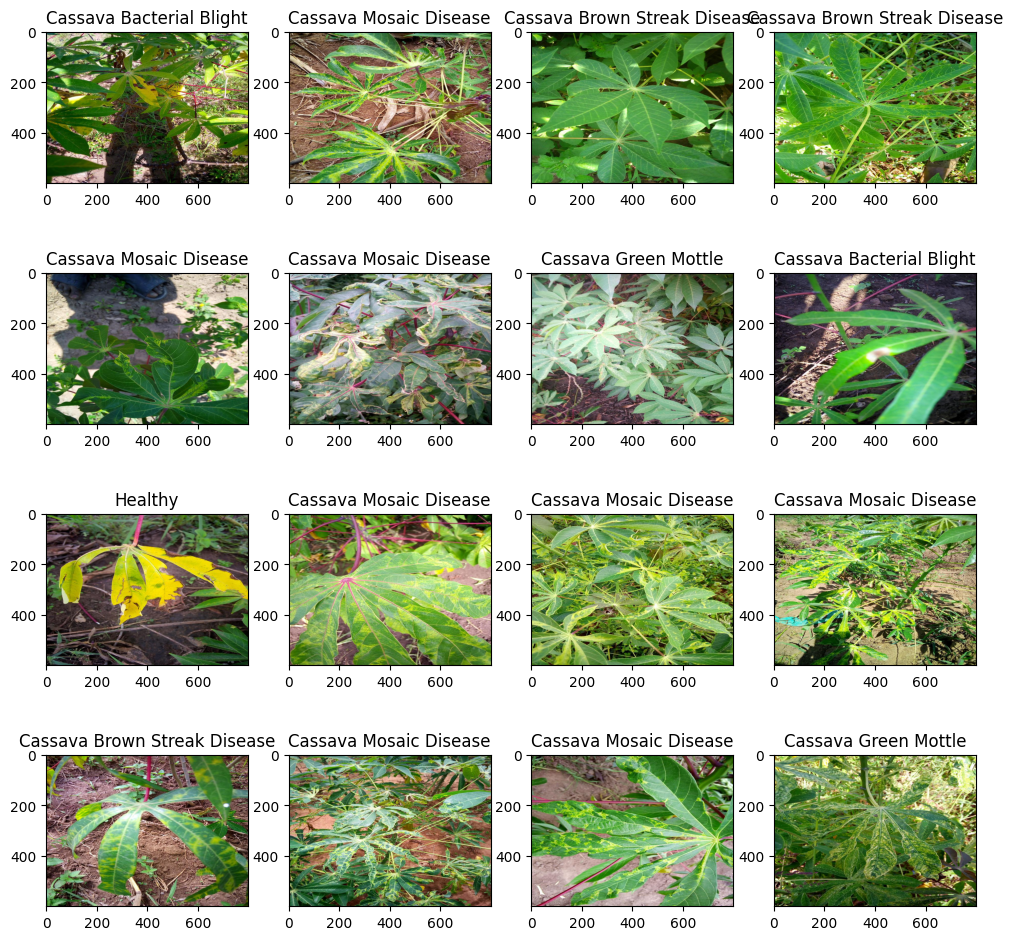

In [3]:
categories = [
    "Cassava Bacterial Blight", 
    "Cassava Brown Streak Disease", 
    "Cassava Green Mottle", 
    "Cassava Mosaic Disease", 
    "Healthy",
]
model_num = 0
data_path = "/kaggle/input/cassava-leaf-disease-classification/"
labels = pd.read_csv(os.path.join(data_path, "train.csv"))
plt.figure(figsize=(12, 12))
for i in range(16):
    label = labels.iloc[i]
    image = Image.open(os.path.join(data_path, "train_images", label.iloc[0]))
    plt.subplot(4,4,i+1%5)
    plt.title(categories[label.iloc[1]])
    plt.imshow(image)

## Create Dataset

In [4]:
class GenericDataset(Dataset):
    def __init__(self, datas, images_path, transform=None):
        super().__init__()
        # Initialize dataset with data and optional transform
        self.datas = datas
        self.image_path = images_path
        self.transform = transform

    def __len__(self):
        # Return the total number of samples
        return len(self.datas)

    def __getitem__(self, idx):
        # Retrieve a single sample by index
        image_name, label = self.datas.iloc[idx]
        image = Image.open(os.path.join(self.image_path, image_name)).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label

In [5]:
def generate_datasets(csv_path, image_path, test_size=0.2, train_transform=None, test_transform=None):
    # Load CSV data
    datas = pd.read_csv(csv_path)

    # Split into training and testing sets
    train_data, test_data = train_test_split(datas, test_size=test_size, random_state=42, shuffle=True)

    # Create Dataset instances
    train_dataset = GenericDataset(train_data, image_path, transform=train_transform)
    test_dataset = GenericDataset(test_data, image_path, transform=test_transform)

    return train_dataset, test_dataset

## Train and test Utils

In [6]:
def train_epoch(model, dataloader, optimizer, device, criterion=torch.nn.CrossEntropyLoss()):
    model.train()
    model.to(device)
    running_loss = 0.0
    all_preds = []
    all_targets = []
    
    for images, labels in tqdm(dataloader, desc="Training", leave=False):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(labels.cpu().numpy())

    avg_loss = running_loss / len(dataloader.dataset)
    accuracy = accuracy_score(all_targets, all_preds)
    precision = precision_score(all_targets, all_preds, average='macro', zero_division=0)
    recall = recall_score(all_targets, all_preds, average='macro', zero_division=0)

    return {
        'loss': avg_loss,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall
    }

In [7]:
def test_epoch(model, dataloader, device, criterion=torch.nn.CrossEntropyLoss()):
    model.eval()
    model.to(device)
    running_loss = 0.0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Validation", leave=False):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)

            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(labels.cpu().numpy())

    avg_loss = running_loss / len(dataloader.dataset)
    accuracy = accuracy_score(all_targets, all_preds)
    precision = precision_score(all_targets, all_preds, average='macro', zero_division=0)
    recall = recall_score(all_targets, all_preds, average='macro', zero_division=0)

    return {
        'loss': avg_loss,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall
    }

In [8]:
def plot_metrics(history):
    metrics = ['loss', 'accuracy', 'precision', 'recall']
    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(16, 10))

    for i, metric in enumerate(metrics):
        plt.subplot(2, 2, i + 1)
        plt.plot(epochs, history[f'train_{metric}'], label=f"Train {metric}")
        plt.plot(epochs, history[f'val_{metric}'], label=f"Val {metric}")
        plt.title(metric.capitalize())
        plt.xlabel('Epoch')
        plt.ylabel(metric)
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.show()

In [9]:
def fit(model, train_loader, val_loader, optimizer, device, num_epochs=10,
        criterion=torch.nn.CrossEntropyLoss(), scheduler=None, model_name="model.pt"):
    # Dictionary to store training history
    history = {
        'train_loss': [],
        'train_accuracy': [],
        'train_precision': [],
        'train_recall': [],
        'val_loss': [],
        'val_accuracy': [],
        'val_precision': [],
        'val_recall': []
    }

    best_val_accuracy = 0.0  # Track best validation accuracy

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")

        # Training and validation steps
        train_metrics = train_epoch(model, train_loader, optimizer, device, criterion)
        val_metrics = test_epoch(model, val_loader, device, criterion)

        # Save the best model based on validation accuracy
        if val_metrics['accuracy'] > best_val_accuracy:
            best_val_accuracy = val_metrics['accuracy']
            torch.save(model.state_dict(), f"best_{model_name}")
            print(f"Best model saved with accuracy {best_val_accuracy:.4f}")

        # Display training and validation results
        print(f"Train — Loss: {train_metrics['loss']:.4f}, Accuracy: {train_metrics['accuracy']:.4f}, "
              f"Precision: {train_metrics['precision']:.4f}, Recall: {train_metrics['recall']:.4f}")
        print(f"Val   — Loss: {val_metrics['loss']:.4f}, Accuracy: {val_metrics['accuracy']:.4f}, "
              f"Precision: {val_metrics['precision']:.4f}, Recall: {val_metrics['recall']:.4f}")

        # Update history with current metrics
        for key in train_metrics:
            history[f'train_{key}'].append(train_metrics[key])
            history[f'val_{key}'].append(val_metrics[key])

        # Scheduler step (if provided)
        if scheduler is not None:
            scheduler.step()

    # Save the final model
    torch.save(model.state_dict(), f"last_{model_name}")

    # Plot training curves
    plot_metrics(history)
    return history

## Loaders and Model

In [10]:
def create_dataloaders(train_set, test_set, batch_size=32, num_workers=2):
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    return train_loader, test_loader

In [11]:
def create_vit_classifier(num_classes, pretrained=True):
    weights = ViT_B_16_Weights.DEFAULT if pretrained else None
    model = vit_b_16(weights=weights)

    in_features = model.heads.head.in_features
    model.heads.head = nn.Linear(in_features, num_classes)

    return model

In [12]:
def create_mobilenetv3_classifier(num_classes, pretrained=True):
    weights = MobileNet_V3_Small_Weights.DEFAULT if pretrained else None
    model = mobilenet_v3_small(weights=weights)
    
    in_features = model.classifier[-1].in_features
    model.classifier[-1] = nn.Linear(in_features, num_classes)
    
    return model

In [13]:
class ViT_MobileNet_Ensemble(nn.Module):
    def __init__(self, num_classes, pretrained=True):
        super(ViT_MobileNet_Ensemble, self).__init__()
        self.vit = create_vit_classifier(num_classes, pretrained)
        self.mobilenet = create_mobilenetv3_classifier(num_classes, pretrained)
        for name, param in self.mobilenet.named_parameters():
            if "classifier.3" not in name:
                param.requires_grad = False

    def forward(self, x):
        vit_out = self.vit(x)          # shape: [B, num_classes]
        mobilenet_out = self.mobilenet(x)  # shape: [B, num_classes]

        # Fusion 
        combined = (vit_out + mobilenet_out) / 2

        return combined  # logits 

## Initialisation

In [14]:
def compute_mean_std_from_path(images_path):
    """
    Computes the mean and standard deviation of RGB channels for all images in a given folder.

    Args:
        images_path (str): Path to the folder containing the images.

    Returns:
        (mean, std): Tuple of tensors containing the per-channel mean and standard deviation.
    """
    to_tensor = transforms.ToTensor()
    mean = torch.zeros(3)
    std = torch.zeros(3)
    nb_images = 0

    image_files = [f for f in os.listdir(images_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

    for img_name in tqdm(image_files, desc="Processing images"):
        img_path = os.path.join(images_path, img_name)
        try:
            img = Image.open(img_path).convert('RGB')
            tensor = to_tensor(img)  # [C, H, W]
            mean += tensor.mean(dim=(1, 2))
            std += tensor.std(dim=(1, 2))
            nb_images += 1
        except Exception as e:
            print(f"Error with {img_name}: {e}")
            continue

    mean /= nb_images
    std /= nb_images

    return mean, std

In [15]:
test_size = 0.2
csv_path = os.path.join(data_path, "train.csv")
image_path = os.path.join(data_path, "train_images")
batch_size=16
num_classes = 5

In [16]:
mean, std = compute_mean_std_from_path(image_path)

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(size=224, scale=(0.8, 1.0), ratio=(0.75, 1.33)),  # crop aléatoire et resize
    transforms.RandomHorizontalFlip(p=0.5),            
    transforms.RandomVerticalFlip(p=0.2),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomRotation(degrees=15),             
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05)),  
    transforms.ToTensor(),
    transforms.Normalize(mean, std)              
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),          
    transforms.ToTensor(),                  
    transforms.Normalize(mean, std)
])

Processing images: 100%|██████████| 21397/21397 [08:07<00:00, 43.86it/s]


In [17]:
train_set, test_set = generate_datasets(csv_path, 
                                        image_path, 
                                        test_size=test_size, 
                                        train_transform=train_transform, 
                                        test_transform=test_transform
                                       )
train_loader, test_loader = create_dataloaders(train_set, test_set, batch_size=batch_size)
model = ViT_MobileNet_Ensemble(num_classes)

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:01<00:00, 222MB/s]  
Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth
100%|██████████| 9.83M/9.83M [00:00<00:00, 98.4MB/s]


## Entrainement

In [18]:
optimizer = AdamW(model.parameters(), lr=1e-4, weight_decay=1e-2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_epochs = 5
criterion = torch.nn.CrossEntropyLoss()
scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs)

training...

Epoch 1/5


Best model saved with accuracy 0.8521
Train — Loss: 0.3318, Accuracy: 0.8830, Precision: 0.8041, Recall: 0.7879
Val   — Loss: 0.4255, Accuracy: 0.8521, Precision: 0.7439, Recall: 0.7270

Epoch 2/5


Best model saved with accuracy 0.8549
Train — Loss: 0.3382, Accuracy: 0.8815, Precision: 0.8021, Recall: 0.7830
Val   — Loss: 0.4281, Accuracy: 0.8549, Precision: 0.7482, Recall: 0.7298

Epoch 3/5


Train — Loss: 0.3697, Accuracy: 0.8693, Precision: 0.7826, Recall: 0.7613
Val   — Loss: 0.4492, Accuracy: 0.8456, Precision: 0.7343, Recall: 0.7165

Epoch 4/5


Train — Loss: 0.4143, Accuracy: 0.8526, Precision: 0.7582, Recall: 0.7348
Val   — Loss: 0.4778, Accuracy: 0.8369, Precision: 0.7172, Recall: 0.7103

Epoch 5/5


Train — Loss: 0.4522, Accuracy: 0.8395, Precision: 0.7409, Recall: 0.7111
Val   — Loss: 0.5082, Accuracy: 0.8294, Precision: 0.7495, Recall: 0.6600


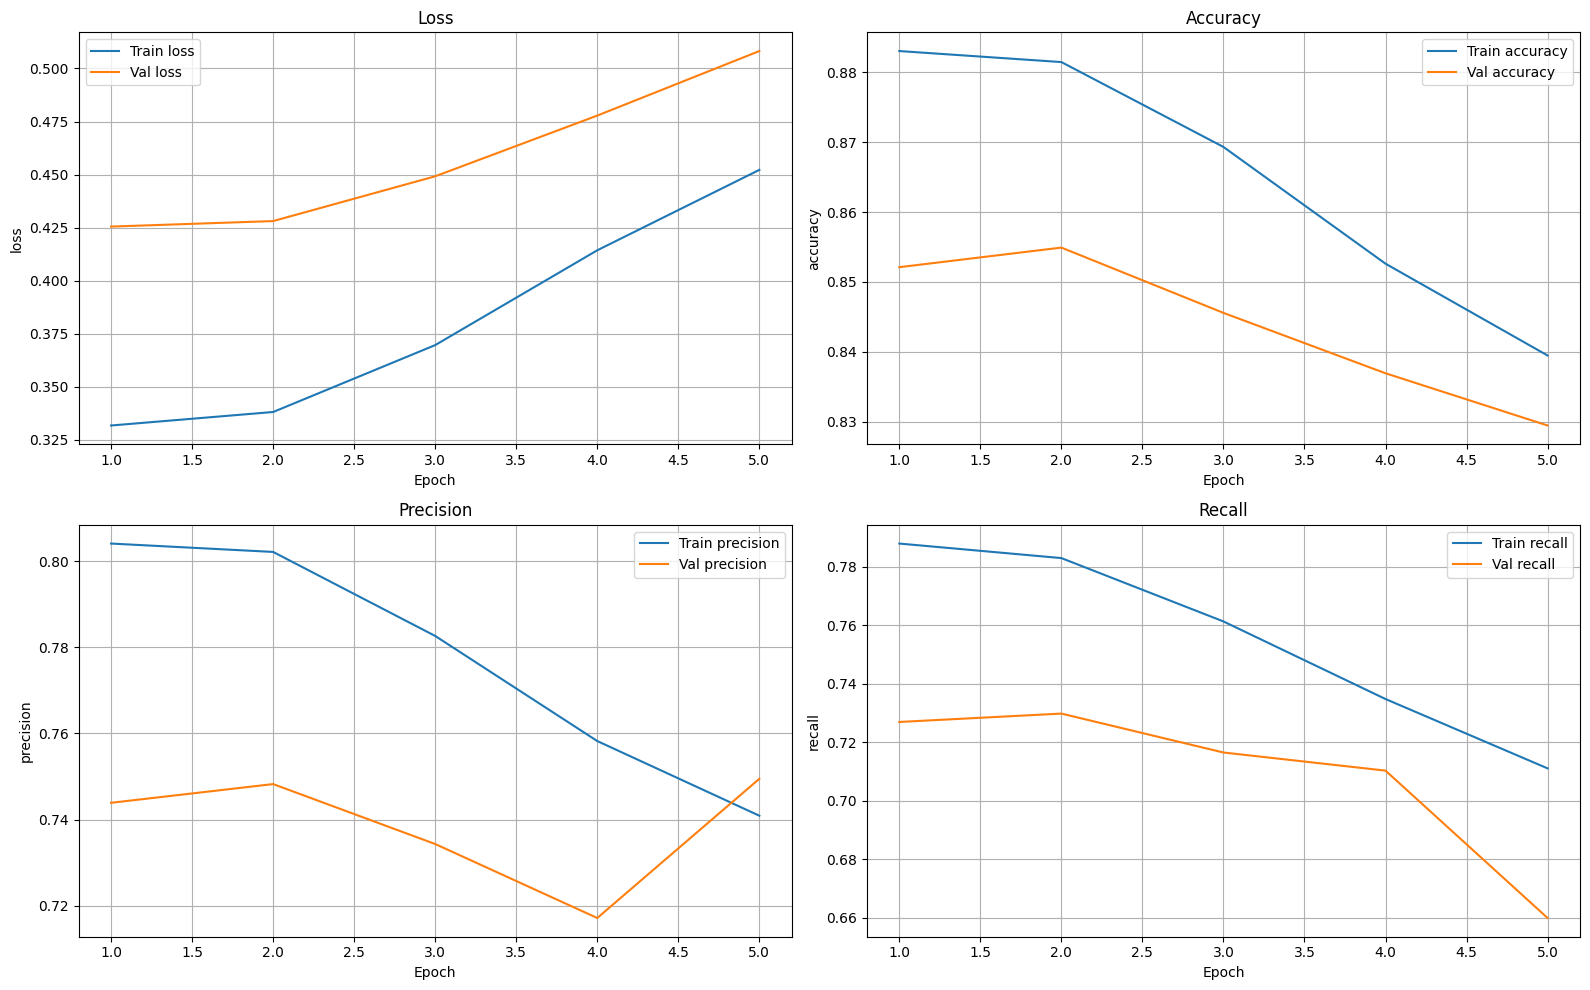

ok


In [22]:
print("training...")
last_model_path = "/kaggle/working/last_model.pt"
best_model_path = "/kaggle/working/best_model.pt"
if os.path.exists(last_model_path):
    model.load_state_dict(torch.load(last_model_path))
history = fit(model, train_loader, test_loader, optimizer, device, num_epochs, criterion, scheduler)
model_num += 1
name, extension = best_model_path.split(".")
os.rename(best_model_path, f"{name}_{model_num}.{extension}")
print("ok")

## Analyse des résultats

In [23]:
def denormalize_image(img_tensor, mean, std):
    """
    Denormalizes a normalized image tensor and returns a uint8 image ready for display.

    Args:
        img_tensor (Tensor): Normalized image tensor (C, H, W) or (H, W, C).
        mean (list or Tensor): Normalization means (e.g., [0.485, 0.456, 0.406]).
        std (list or Tensor): Normalization standard deviations (e.g., [0.229, 0.224, 0.225]).

    Returns:
        np.ndarray: Image in (H, W, C) format as uint8 with values in [0, 255].
    """
    img_tensor = img_tensor.cpu()

    # Convert mean and std to tensors if not already
    if not isinstance(mean, torch.Tensor):
        mean = torch.tensor(mean)
    if not isinstance(std, torch.Tensor):
        std = torch.tensor(std)

    # Reshape to match image tensor
    mean = mean.view(-1, 1, 1)
    std = std.view(-1, 1, 1)

    # Ensure image tensor is in (C, H, W) format
    if img_tensor.shape[0] != 3 and img_tensor.shape[-1] == 3:
        img_tensor = img_tensor.permute(2, 0, 1)

    # Denormalize
    img = img_tensor * std + mean
    img = img.clamp(0, 1)

    # Convert to (H, W, C) numpy array
    img_np = img.permute(1, 2, 0).numpy()
    img_np = (img_np * 255).astype(np.uint8)

    return img_np

In [24]:
GREEN = (0, 1, 0)
RED = (1, 0, 0)

def show_predictions(model, test_dataset, device, class_names, n=16):
    model.eval()
    model.to(device)

    loader = DataLoader(test_dataset, batch_size=n, shuffle=False)
    images, labels = next(iter(loader))
    images = images.to(device)

    with torch.no_grad():
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)

    images = images.cpu()
    labels = labels.cpu()
    preds = preds.cpu()

    plt.figure(figsize=(12, 12))
    for i in range(n):
        plt.subplot(4, 4, i+1)
        img = denormalize_image(images[i], mean, std)

        plt.imshow(img)
        plt.axis("off")

        correct = preds[i] == labels[i]
        color = GREEN if correct else RED
        label_text = f"{class_names[preds[i]]}"
        plt.title(label_text, color=color, fontsize=10)

    plt.tight_layout()
    plt.show()

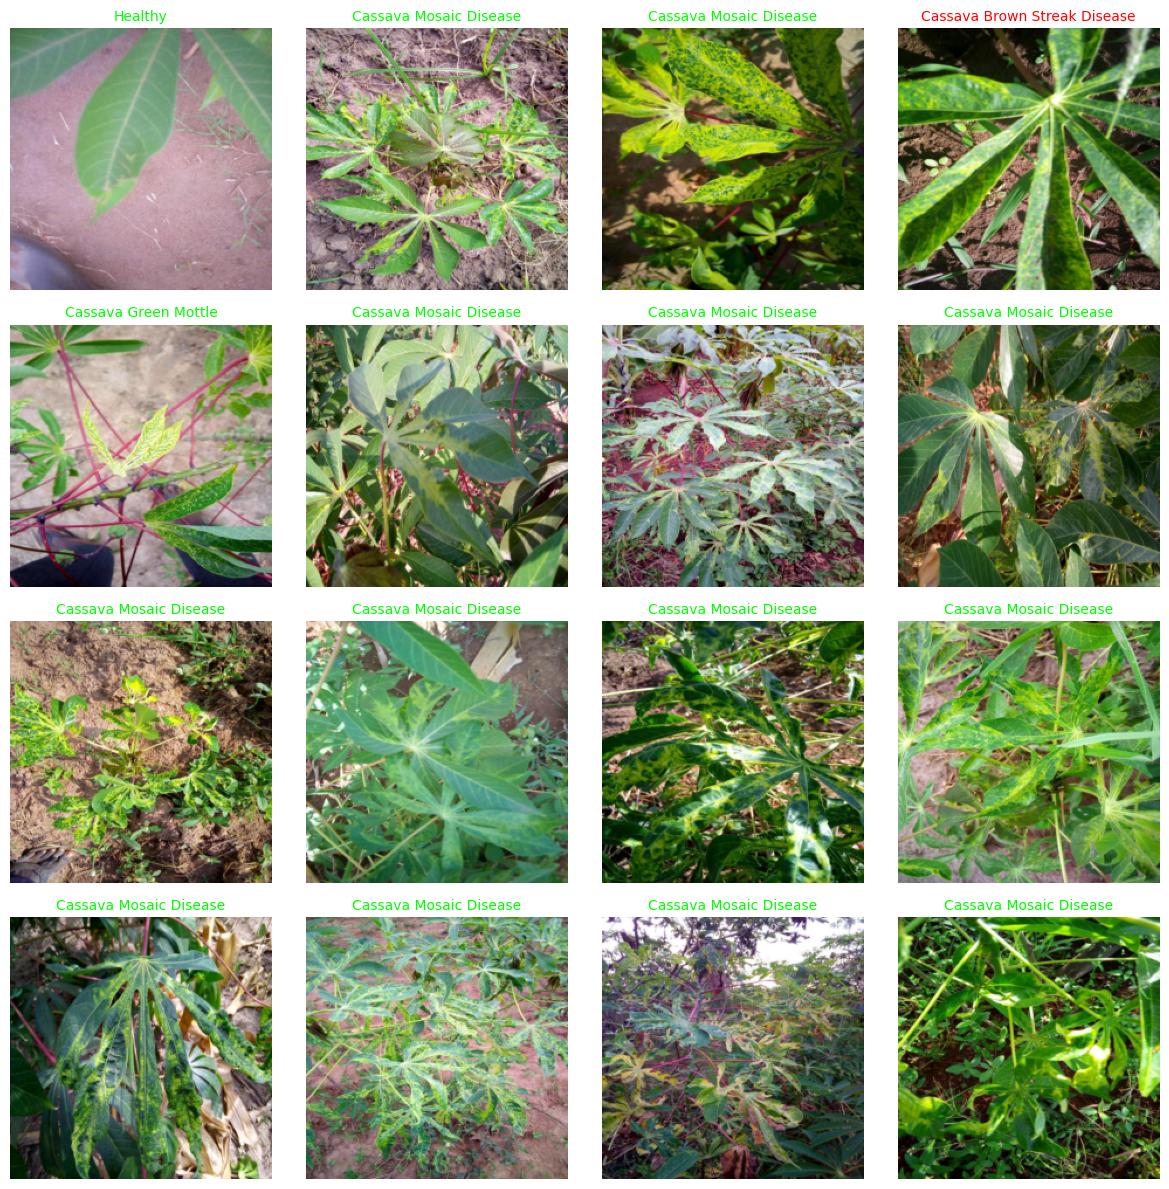

In [25]:
model.load_state_dict(torch.load(f"{name}_{model_num}.{extension}"))
show_predictions(model, test_set, device, categories, n=16)

## Submission

In [26]:
def classify_images_to_csv(model, image_dir, transform, device, output_csv_path):
    """
    Classifies images in a directory and writes predictions to a CSV file.

    Args:
        model (torch.nn.Module): The trained PyTorch model.
        image_dir (str): Path to the directory containing images.
        transform (callable): Transformations to apply to images.
        device (torch.device): CPU or GPU.
        output_csv_path (str): Path to the output CSV file.

    Output:
        A CSV file with the format:
        image_id,label
        filename.jpg,class
    """
    model.eval()
    model.to(device)

    results = []

    image_filenames = [f for f in os.listdir(image_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

    for image_name in tqdm(image_filenames, desc="Classifying images"):
        image_path = os.path.join(image_dir, image_name)

        try:
            image = Image.open(image_path).convert("RGB")
            image_tensor = transform(image).unsqueeze(0).to(device)

            with torch.no_grad():
                outputs = model(image_tensor)
                predicted_class = outputs.argmax(dim=1).item()

            results.append({'image_id': image_name, 'label': predicted_class})

        except Exception as e:
            print(f"Error for {image_name}: {e}")

    # Save predictions to a CSV file
    df = pd.DataFrame(results)
    df.to_csv(output_csv_path, index=False)
    print(f"\nCSV saved to: {output_csv_path}")

In [27]:
image_dir = os.path.join(data_path, "test_images")
classify_images_to_csv(model, image_dir, test_transform, device, "submission.csv")

Classifying images: 100%|██████████| 1/1 [00:00<00:00,  2.93it/s]


CSV sauvegardé dans : submission.csv
